# 📃 Solution for Exercise M4.03

Now, we tackle a (relatively) realistic classification problem instead of making
a synthetic dataset. We start by loading the Adult Census dataset with the
following snippet. For the moment we retain only the **numerical features**.

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")
target = adult_census["class"]
data = adult_census.select_dtypes(["integer", "floating"])
data = data.drop(columns=["education-num"])
data

,age,capital-gain,capital-loss,hours-per-week
0,25,0,0,40
1,38,0,0,50
2,28,0,0,40
3,44,7688,0,40
4,18,0,0,30
...,...,...,...,...
48837,27,0,0,38
48838,40,0,0,40
48839,58,0,0,40
48840,22,0,0,20


We confirm that all the selected features are numerical.

Define a linear model composed of a `StandardScaler` followed by a
`LogisticRegression` with default parameters.

Then use a 10-fold cross-validation to estimate its generalization performance
in terms of accuracy. Also set `return_estimator=True` to be able to inspect
the trained estimators.

In [2]:
# solution
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

model = make_pipeline(StandardScaler(), LogisticRegression())
cv_results_lr = cross_validate(
    model, data, target, cv=10, return_estimator=True
)
test_score_lr = cv_results_lr["test_score"]
test_score_lr

array([0.79856704, 0.79283521, 0.79668305, 0.80487305, 0.80036855,
       0.79914005, 0.79750205, 0.7993448 , 0.80528256, 0.80405405])

What is the most important feature seen by the logistic regression?

You can use a boxplot to compare the absolute values of the coefficients while
also visualizing the variability induced by the cross-validation resampling.

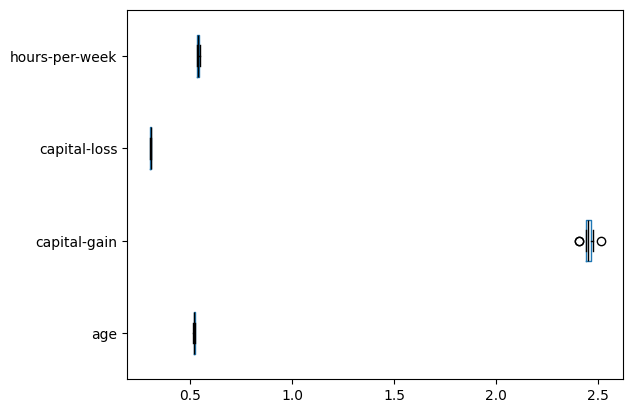

In [3]:
# solution
import matplotlib.pyplot as plt

coefs = [pipeline[-1].coef_[0] for pipeline in cv_results_lr["estimator"]]
coefs = pd.DataFrame(coefs, columns=data.columns)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
_, ax = plt.subplots()
_ = coefs.abs().plot.box(color=color, vert=False, ax=ax)

Since we scaled the features, the coefficients of the linear model can be
meaningful compared directly. `"capital-gain"` is the most impacting feature.
Just be aware not to draw conclusions on the causal effect provided the impact
of a feature. Interested readers are referred to the [example on Common
pitfalls in the interpretation of coefficients of linear
models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)
or the [example on Failure of Machine Learning to infer causal
effects](https://scikit-learn.org/stable/auto_examples/inspection/plot_causal_interpretation.html).

Let's now work with **both numerical and categorical features**. You can
reload the Adult Census dataset with the following snippet:

In [4]:
adult_census = pd.read_csv("../datasets/adult-census.csv")
target = adult_census["class"]
data = adult_census.drop(columns=["class", "education-num"])

Create a predictive model where:
- The numerical data must be scaled.
- The categorical data must be one-hot encoded, set `min_frequency=0.01` to
  group categories concerning less than 1% of the total samples.
- The predictor is a `LogisticRegression` with default parameters, except that
  you may need to increase the number of `max_iter`, which is 100 by default.

Use the same 10-fold cross-validation strategy with `return_estimator=True` as
above to evaluate the full pipeline, including the feature scaling and encoding
preprocessing.

In [5]:
# solution
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = selector(dtype_include=object)(data)
numerical_columns = selector(dtype_exclude=object)(data)

preprocessor = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore", min_frequency=0.01),
        categorical_columns,
    ),
    (StandardScaler(), numerical_columns),
)
model = make_pipeline(preprocessor, LogisticRegression(max_iter=5_000))
cv_results_complex_lr = cross_validate(
    model, data, target, cv=10, return_estimator=True, n_jobs=2
)
test_score_complex_lr = cv_results_complex_lr["test_score"]
test_score_complex_lr

array([0.85281474, 0.85056295, 0.84971335, 0.8474611 , 0.84807535,
       0.84684685, 0.85565111, 0.8507371 , 0.85872236, 0.8515561 ])

By comparing the cross-validation test scores of both models fold-to-fold,
count the number of times the model using both numerical and categorical
features has a better test score than the model using only numerical features.

A model using both all features is better than a model using only numerical features for 10 CV iterations out of 10.


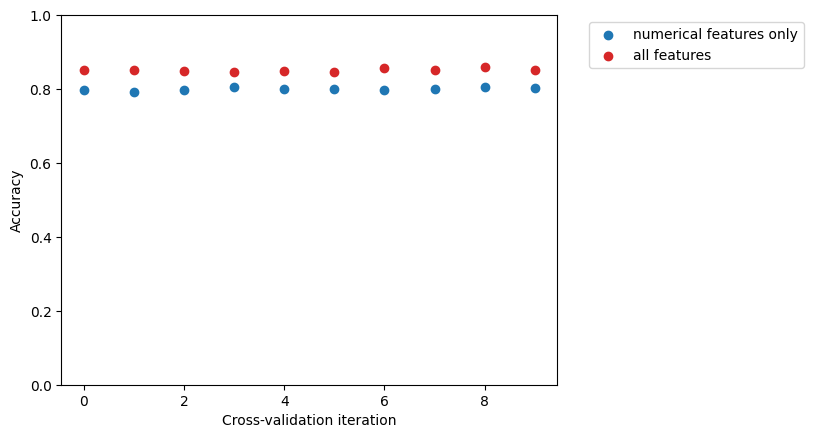

In [6]:
# solution
import numpy as np
import matplotlib.pyplot as plt

indices = np.arange(len(test_score_lr))
plt.scatter(
    indices, test_score_lr, color="tab:blue", label="numerical features only"
)
plt.scatter(
    indices,
    test_score_complex_lr,
    color="tab:red",
    label="all features",
)
plt.ylim((0, 1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("Accuracy")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print(
    "A model using both all features is better than a"
    " model using only numerical features for"
    f" {sum(test_score_complex_lr > test_score_lr)} CV iterations out of 10."
)

For the following questions, you can copy and paste the following snippet to
get the feature names from the column transformer here named `preprocessor`.

```python
preprocessor.fit(data)
feature_names = (
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_columns
    )
).tolist()
feature_names += numerical_columns
feature_names
```

In [7]:
# solution
preprocessor.fit(data)
feature_names = (
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_columns
    )
).tolist()
feature_names += numerical_columns
feature_names

['workclass_ ?',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_infrequent_sklearn',
 'education_ 10th',
 'education_ 11th',
 'education_ 12th',
 'education_ 5th-6th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Assoc-acdm',
 'education_ Assoc-voc',
 'education_ Bachelors',
 'education_ Doctorate',
 'education_ HS-grad',
 'education_ Masters',
 'education_ Prof-school',
 'education_ Some-college',
 'education_infrequent_sklearn',
 'marital-status_ Divorced',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'marital-status_infrequent_sklearn',
 'occupation_ ?',
 'occupation_ Adm-clerical',
 'occupation_ Craft-repair',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Ma

Notice that there are as many feature names as coefficients in the last step
of your predictive pipeline.

Which of the following pairs of features is most impacting the predictions of
the logistic regression classifier based on the absolute magnitude of its
coefficients?

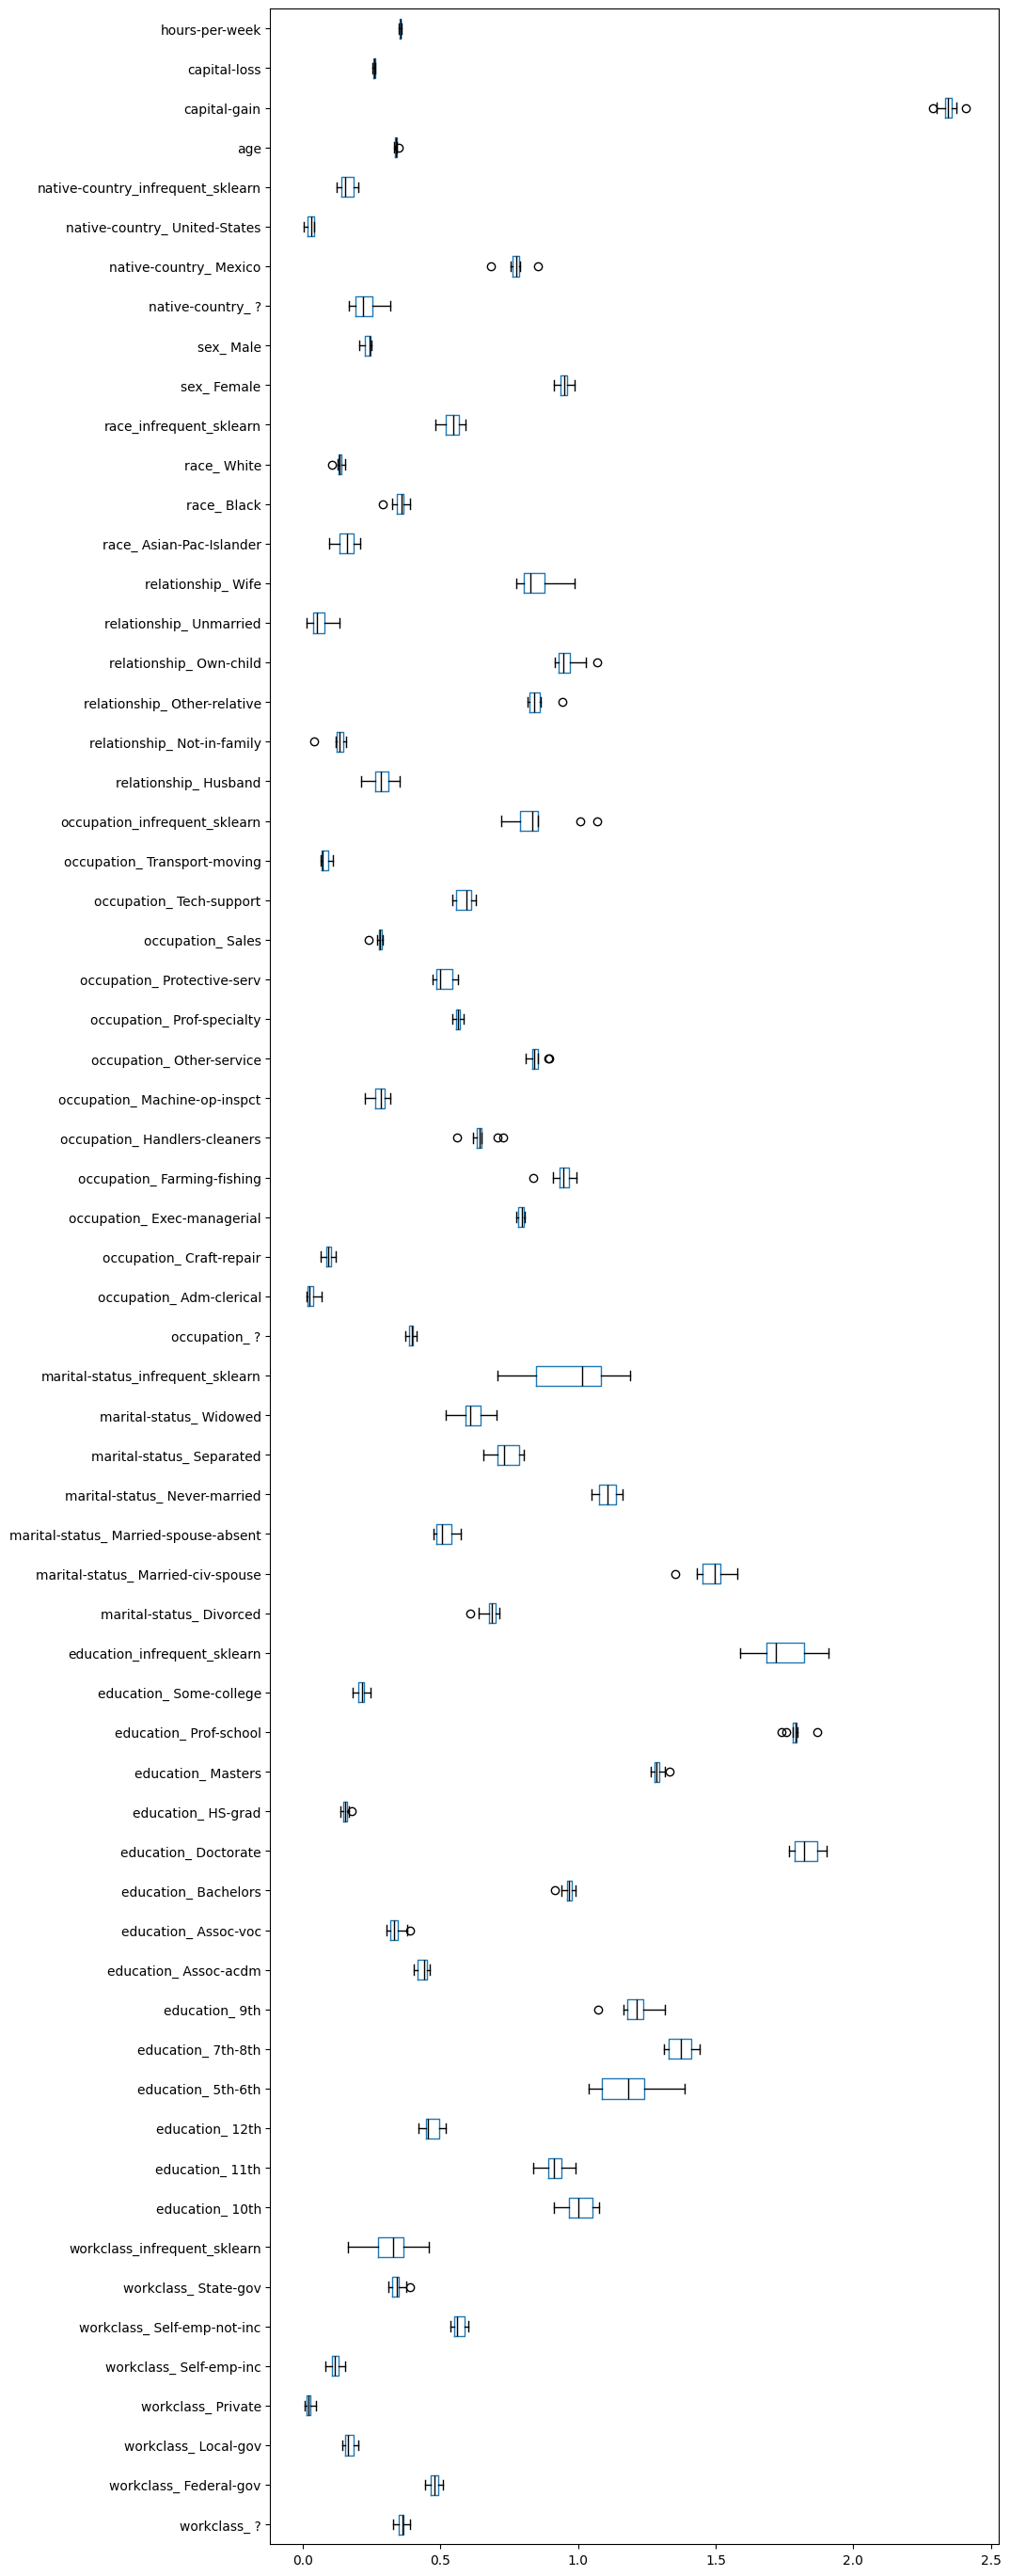

In [8]:
# solution
coefs = [
    pipeline[-1].coef_[0] for pipeline in cv_results_complex_lr["estimator"]
]
coefs = pd.DataFrame(coefs, columns=feature_names)

_, ax = plt.subplots(figsize=(10, 35))
_ = coefs.abs().plot.box(color=color, vert=False, ax=ax)

We can visually inspect the coefficients and observe that `"capital-gain"` and
`"education_Doctorate"` are impacting the predictions the most.

Now create a similar pipeline consisting of the same preprocessor as above,
followed by a `PolynomialFeatures` and a logistic regression with `C=0.01` and
enough `max_iter`. Set `degree=2` and `interaction_only=True` to the feature
engineering step. Remember not to include a "bias" feature to avoid
introducing a redundancy with the intercept of the subsequent logistic
regression.

In [9]:
# solution
from sklearn.preprocessing import PolynomialFeatures

model_with_interactions = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    LogisticRegression(C=0.01, max_iter=5_000),
)
model_with_interactions

,steps,"[('columntransformer', ...), ('polynomialfeatures', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('standardscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Use the same 10-fold cross-validation strategy as above to evaluate this
pipeline with interactions. In this case there is no need to return the
estimator, as the number of features generated by the `PolynomialFeatures` step
is much too large to be able to visually explore the learned coefficients of the
final classifier.

By comparing the cross-validation test scores of both models fold-to-fold,
count the number of times the model using multiplicative interactions and both
numerical and categorical features has a better test score than the model
without interactions.

In [10]:
# solution
cv_results_interactions = cross_validate(
    model_with_interactions,
    data,
    target,
    cv=10,
    n_jobs=2,
)
test_score_interactions = cv_results_interactions["test_score"]
test_score_interactions

array([0.85383828, 0.85383828, 0.8527846 , 0.85298935, 0.84930385,
       0.8503276 , 0.85462735, 0.8523751 , 0.85565111, 0.85176085])

A model using all features and interactions is better than a model without interactions for 8 CV iterations out of 10.


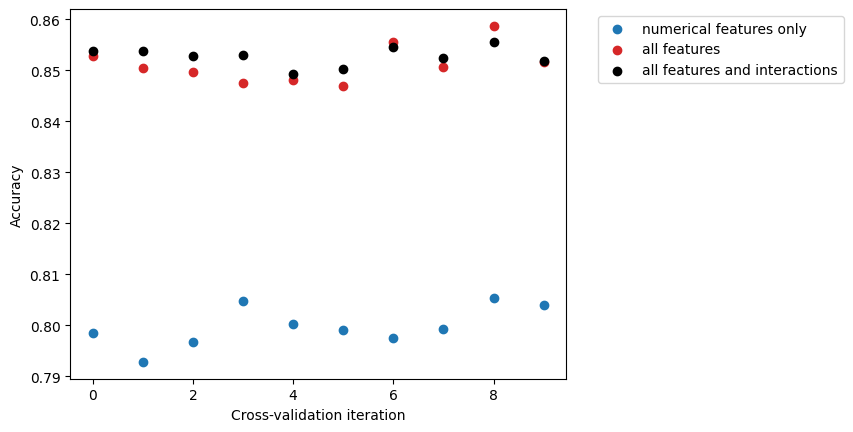

In [11]:
# solution
plt.scatter(
    indices, test_score_lr, color="tab:blue", label="numerical features only"
)
plt.scatter(
    indices,
    test_score_complex_lr,
    color="tab:red",
    label="all features",
)
plt.scatter(
    indices,
    test_score_interactions,
    color="black",
    label="all features and interactions",
)
plt.xlabel("Cross-validation iteration")
plt.ylabel("Accuracy")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print(
    "A model using all features and interactions is better than a model"
    " without interactions for"
    f" {sum(test_score_interactions > test_score_complex_lr)} CV iterations"
    " out of 10."
)

When you multiply two one-hot encoded categorical features, the resulting
interaction feature is mostly 0, with a 1 only when both original features are
active, acting as a logical `AND`. In this case it could mean we are creating
new rules such as "has a given education `AND` a given native country", which
we expect to be predictive. This new rules map the original feature space into
a higher dimension space, where the linear model can separate the data more
easily.

Keep into account that multiplying all pairs of one-hot encoded features may
lead to a rapid increase in the number of features, especially if the original
categorical variables have many levels. This can increase the computational
cost of your model and promote overfitting, as we will see in a future
notebook.